In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import h5py

In [2]:
import utils

In [3]:
import warnings
warnings.filterwarnings("ignore")

# Read data

In [4]:
metadata = pd.read_csv('../data/plasticc/plasticc_train_metadata.csv.gz')
data = pd.read_csv('../data/plasticc/plasticc_train_lightcurves.csv.gz')

data = data[data.detected_bool == 1]

In [5]:
metadata.head()

,object_id,ra,decl,ddf_bool,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target,...,true_rv,true_av,true_peakmjd,libid_cadence,tflux_u,tflux_g,tflux_r,tflux_i,tflux_z,tflux_y
0,615,349.0461,-61.9438,1,0.000,0.000,0.000,-9.000,0.017,92,...,0.0,0.0,59570.000,69,484.7,3286.7,3214.1,3039.7,2854.5,2837.0
1,713,53.0859,-27.7844,1,1.818,1.627,0.255,45.406,0.007,88,...,0.0,0.0,59570.000,34,108.7,117.7,119.9,149.6,147.9,150.5
2,730,33.5742,-6.5796,1,0.232,0.226,0.016,40.256,0.021,42,...,0.0,0.0,60444.379,9,0.0,0.0,0.0,0.0,0.0,0.0
3,745,0.1899,-45.5867,1,0.304,0.281,1.152,40.795,0.007,90,...,0.0,0.0,60130.453,38,0.0,0.0,0.0,0.0,0.0,0.0
4,1124,352.7113,-63.8237,1,0.193,0.241,0.018,40.417,0.024,90,...,0.0,0.0,60452.641,1,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
data.head()

,object_id,mjd,passband,flux,flux_err,detected_bool
0,615,59750.4229,2,-544.810303,3.622952,1
1,615,59750.4306,1,-816.434326,5.553370,1
2,615,59750.4383,3,-471.385529,3.801213,1
3,615,59750.4450,4,-388.984985,11.395031,1
4,615,59752.4070,2,-681.858887,4.041204,1


In [7]:
object_ids = np.unique(data.object_id)

In [8]:
passband2name = {0: 'u', 1: 'g', 2: 'r', 3: 'i', 4: 'z', 5: 'y'}
passband2lam  = {0: np.log10(3751.36), 1: np.log10(4741.64), 2: np.log10(6173.23), 
                 3: np.log10(7501.62), 4: np.log10(8679.19), 5: np.log10(9711.53)}

# Visual analysis

In [9]:
def get_object(data, object_id):
    anobject = data[data.object_id == object_id]
    return anobject

In [10]:
def get_passband(anobject, passband):
    light_curve = anobject[anobject.passband == passband]
    return light_curve

In [11]:
def add_log_lam(anobject):
    passbands = anobject.passband.values
    log_lam = [passband2lam[i] for i in passbands]
    anobject['log_lam'] = log_lam
    return anobject

In [12]:
def create_approx_object(anobject, n=1000):
    mjd = anobject['mjd'].values
    dfs = []
    for passband in range(6):
        df = pd.DataFrame()
        df['mjd'] = np.linspace(mjd.min(), mjd.max(), n)
        df['object_id'] = 0
        df['passband'] = passband
        df['flux'] = 0
        df['flux_err'] = 0
        df['detected_bool'] = 1
        dfs.append(df)
    new_object = pd.concat(dfs, axis=0)
    new_object = add_log_lam(new_object)
    return new_object

In [13]:
def is_good(anobject):
    good = 1
    
    # remove all objects with negative flux values
    if anobject['flux'].values.min() < 0:
        good = 0
    
    # keep only objects with at least 10 observations in at least 3 passbands
    count = 0
    for passband in range(6):
        if len(get_passband(anobject, passband)) < 10:
            count += 1
    if count > 3:
        good = 0
        
    # keep only objects without large breaks in observations
    anobject = anobject.sort_values('mjd')
    mjd = anobject['mjd'].values
    if np.diff(mjd, 1).max() > 50:
        good = 0
    
    return good

In [14]:
def plot_light_curves(anobject, title=""):
    anobject = anobject.sort_values('mjd')
    plt.figure(figsize=(9, 4))
    for passband in range(6):
        light_curve = get_passband(anobject, passband)
        plt.plot(light_curve['mjd'].values, light_curve['flux'].values, linewidth=0.5)
        plt.scatter(light_curve['mjd'].values, light_curve['flux'].values, label=passband2name[passband], linewidth=1)
    plt.xlabel('Modified Julian Date', size=14)
    plt.xticks(size=14)
    plt.ylabel('Flux', size=14)
    plt.yticks(size=14)
    plt.legend(loc='best', ncol=3, fontsize=14)
    plt.title(title, size=14)

In [15]:
def plot_light_curves_with_sigma(anobject, anobject_real, title=""):
    anobject = anobject.sort_values('mjd')
    colors = ['C'+str(i) for i in range(6)]
    plt.figure(figsize=(9, 4))
    for passband in range(6):
        light_curve = get_passband(anobject, passband)
        light_curve_real = get_passband(anobject_real, passband)
        plt.plot(light_curve['mjd'].values, light_curve['flux'].values, linewidth=2., color=colors[passband])
        plt.fill_between(light_curve['mjd'].values, 
                         light_curve['flux'].values+3*light_curve['flux_err'].values, 
                         light_curve['flux'].values-3*light_curve['flux_err'].values, label=passband2name[passband], alpha=0.5, color=colors[passband])
        plt.scatter(light_curve_real['mjd'].values, light_curve_real['flux'].values, linewidth=1, color=colors[passband])
    plt.xlabel('Modified Julian Date', size=14)
    plt.xticks(size=14)
    plt.ylabel('Flux', size=14)
    plt.yticks(size=14)
    plt.legend(loc='best', ncol=3, fontsize=14)
    plt.title(title, size=14)

34299


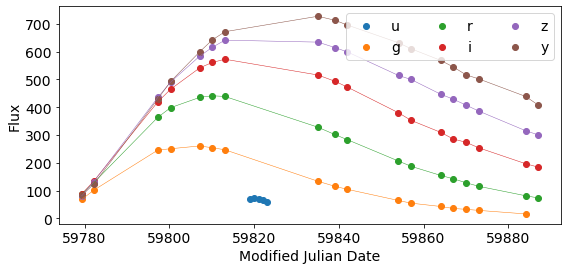

43812


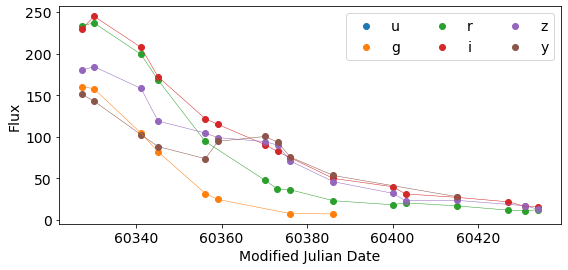

70046


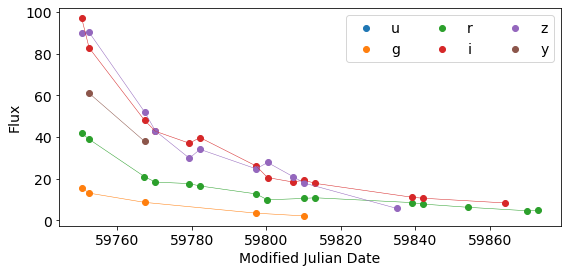

84716


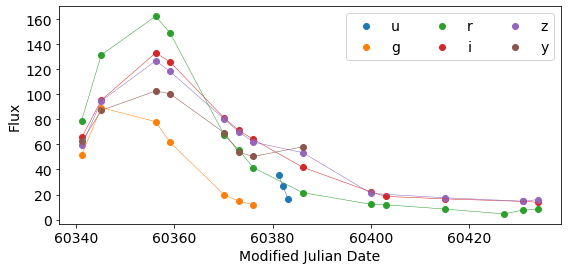

131629


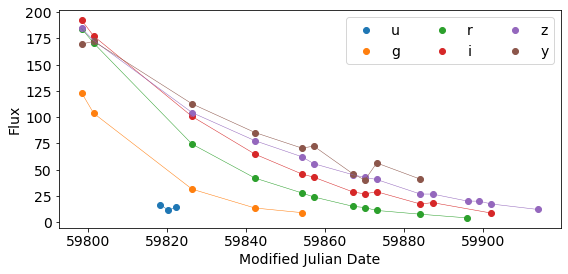

169315


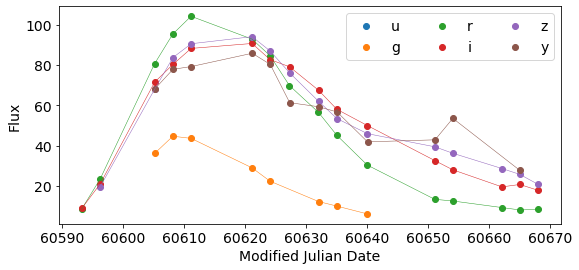

229855


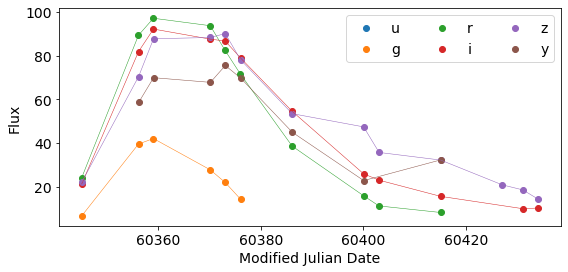

251430


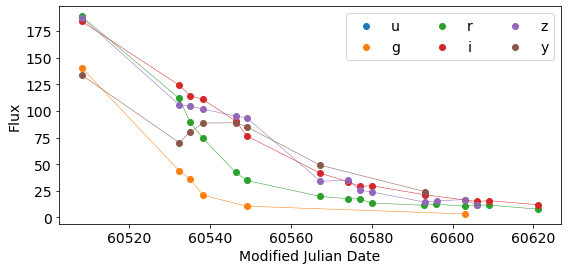

282714


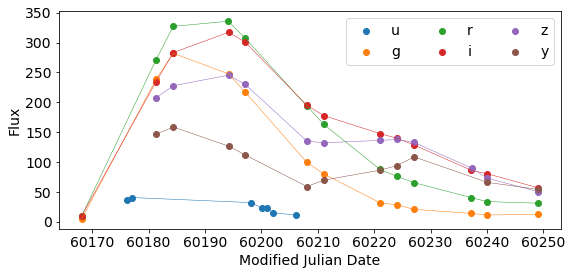

290682


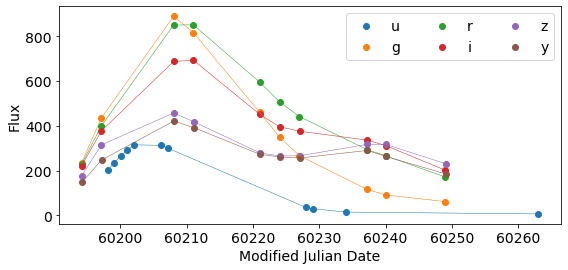

316306


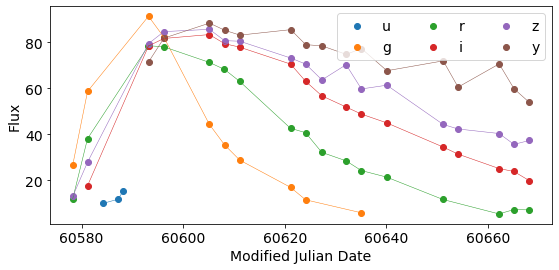

In [16]:
for i in object_ids[::50]:
    anobject = get_object(data, i)
    
    if not is_good(anobject): continue
    print(i)
    
    plot_light_curves(anobject)
    plt.show()

# BNN

In [17]:
#!pip install torchbnn

In [18]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler

import torchbnn as bnn

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'

class BNNRegressor(nn.Module):
    def __init__(self, n_inputs=1, n_hidden=10):
        super(BNNRegressor, self).__init__()
        
        self.model = nn.Sequential(
                                bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=n_inputs, out_features=n_hidden),
                                nn.Tanh(),
                                bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=n_hidden, out_features=1))

    def forward(self, x):
        return self.model(x)
    
    
class FitBNNRegressor(object):
    
    def __init__(self, n_hidden=10, n_epochs=10, lr=0.01, kl_weight=0.1, optimizer='Adam', debug=0):        
        self.model = None
        self.n_hidden = n_hidden
        self.n_epochs = n_epochs
        self.lr = lr
        self.kl_weight = kl_weight
        self.optimizer = optimizer
        self.debug = debug
        
    
    def fit(self, X, y):
        # Estimate model
        self.model = BNNRegressor(n_inputs=X.shape[1], n_hidden=self.n_hidden)
        self.model.to(device)
        # Convert X and y into torch tensors
        X_tensor = torch.as_tensor(X, dtype=torch.float32, device=device)
        y_tensor = torch.as_tensor(y.reshape(-1, 1), dtype=torch.float32, device=device)
        # Estimate loss
        mse_loss = nn.MSELoss()
        kl_loss  = bnn.BKLLoss(reduction='mean', last_layer_only=False)
        # Estimate optimizer
        if self.optimizer == "Adam":
            opt = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        elif self.optimizer == "SGD":
            opt = torch.optim.SGD(self.model.parameters(), lr=self.lr)
        elif self.optimizer == "RMSprop":
            opt = torch.optim.RMSprop(self.model.parameters(), lr=self.lr)
        else:
            opt = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        # Enable droout
        self.model.train(True)
        # Start the model fit
        for epoch_i in range(self.n_epochs):
            y_pred = self.model(X_tensor)
            mse = mse_loss(y_pred, y_tensor)
            kl = kl_loss(self.model)
            loss = mse + self.kl_weight*kl
            opt.zero_grad()
            loss.backward()
            opt.step()   
    
    def predict(self, X, n_times=1):
        # Disable droout
        self.model.train(False)
        # Convert X and y into torch tensors
        X_tensor = torch.as_tensor(X, dtype=torch.float32, device=device)
        # Make predictions for X
        y_pred = self.model(X_tensor)
        y_pred = y_pred.cpu().detach().numpy()
        return y_pred
    
    def predict_n_times(self, X, n_times=100):
        predictions = []
        for i in range(n_times):
            y_pred = self.predict(X)
            predictions.append(y_pred)
        predictions = np.array(predictions)
        mean = predictions.mean(axis=0)
        std = predictions.std(axis=0)
        return mean, std

# One object test Test

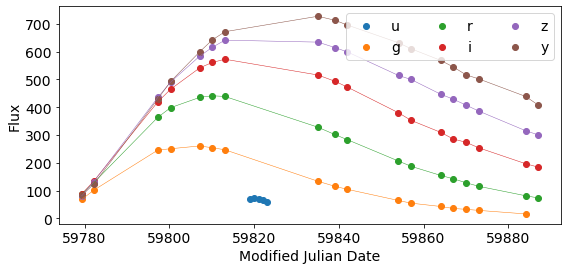

In [19]:
anobject = get_object(data, 34299)
anobject = add_log_lam(anobject)

plot_light_curves(anobject)
plt.savefig('light_curve_34299.pdf', format='pdf')

In [20]:
MODEL = "BNN"

In [21]:
%%time
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic, WhiteKernel, ConstantKernel as C
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

anobject_train, anobject_test = train_test_split(anobject, test_size=0.5, random_state=11)

X_train = anobject_train[['mjd', 'log_lam']].values
X_test = anobject_test[['mjd', 'log_lam']].values

y_train = anobject_train['flux'].values
y_test  = anobject_test['flux'].values

ss = StandardScaler()
X_train_ss = ss.fit_transform(X_train)
X_test_ss = ss.transform(X_test)

# fit a regression model to approximate light curves
if MODEL == "BNN":   
    reg = FitBNNRegressor(n_hidden=200, n_epochs=1000, lr=0.1, kl_weight=0.5, optimizer='Adam', debug=0)
elif MODEL == "GP":
    kernel = C(1.0) * RBF([1.0, 1.0]) + WhiteKernel()
    reg = GaussianProcessRegressor(kernel=kernel, normalize_y=True, n_restarts_optimizer=5, optimizer="fmin_l_bfgs_b", random_state=42)

reg.fit(X_train_ss, y_train)

# predict flux for unseen observations
anobject_test_pred = anobject_test.copy()
anobject_test_pred['flux'] = reg.predict(X_test_ss)
#anobject_test_pred['flux'], _ = reg.predict_n_times(X_test_ss)

# predict flux for known observations
anobject_train_pred = anobject_train.copy()
anobject_train_pred['flux'] = reg.predict(X_train_ss)
#anobject_train_pred['flux'], _ = reg.predict_n_times(X_train_ss)

CPU times: user 6.36 s, sys: 349 ms, total: 6.71 s
Wall time: 2.25 s


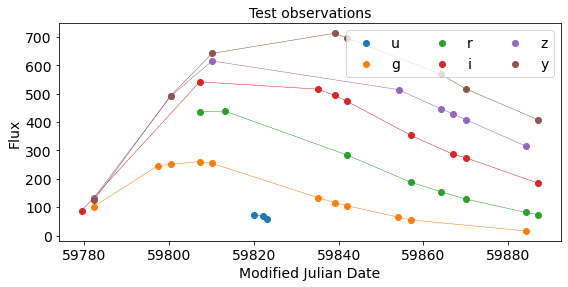

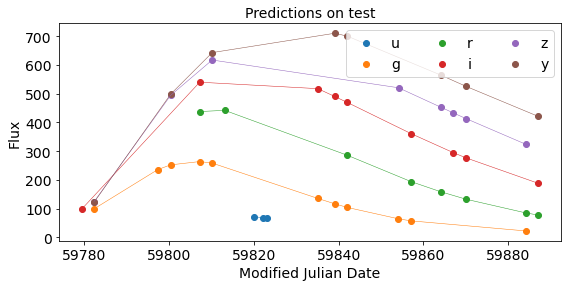

In [22]:
plot_light_curves(anobject_test, "Test observations")
plot_light_curves(anobject_test_pred, "Predictions on test")

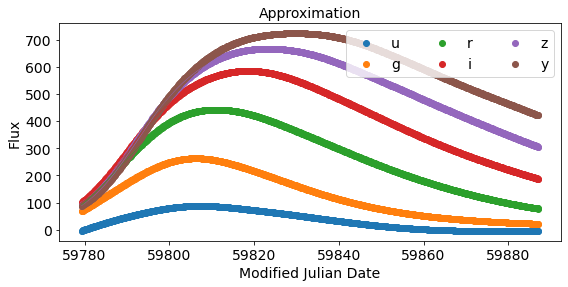

In [23]:
approx_object = create_approx_object(anobject)
X = approx_object[['mjd', 'log_lam']].values
X_ss = ss.transform(X)
approx_object['flux'] = reg.predict(X_ss)
plot_light_curves(approx_object, "Approximation")
plt.savefig('approx_light_curve_34299.pdf', format='pdf')

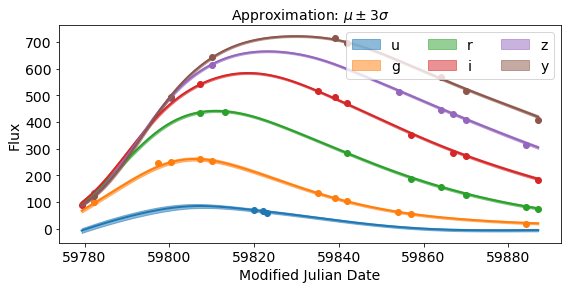

In [24]:
approx_object = create_approx_object(anobject)
X = approx_object[['mjd', 'log_lam']].values
X_ss = ss.transform(X)
if MODEL == "BNN":
    approx_object['flux'], approx_object['flux_err'] = reg.predict_n_times(X_ss, n_times=1000)
elif MODEL == "GP":
    approx_object['flux'], approx_object['flux_err'] = reg.predict(X_ss, return_std=True)
plot_light_curves_with_sigma(approx_object, anobject_test, "Approximation: " + r"$\mu \pm 3\sigma$")
plt.savefig('approx_light_curve_34299.pdf', format='pdf')

In [25]:
# calculate quality metrics
[rmse, mae, rse, rae, mape] = utils.regression_quality_metrics_report(anobject_test['flux'].values, 
                                                                      anobject_test_pred['flux'].values)
print("RMSE: ", rmse)
print("MAE: ", mae)
print("RSE: ", rse)
print("RAE: ", rae)
print("MAPE: ", mape)

RMSE:  5.375261048916391
MAE:  4.4192361832794775
RSE:  0.027131366927810593
RAE:  0.025236358218697918
MAPE:  3.001326341405316


# Test on many objects

In [26]:
from joblib import Parallel, delayed

In [27]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic, WhiteKernel, ConstantKernel as C
from sklearn.preprocessing import StandardScaler

def one_object_run(i):
    
    # get an object
    anobject = get_object(data, i)
    anobject = add_log_lam(anobject)
    
    if not is_good(anobject): 
        return None
    
    # print("Object ", i, " with ", len(anobject), " observations")
    
    # train / test split
    anobject_train, anobject_test = train_test_split(anobject, test_size=0.2, random_state=11)
    
    X_train = anobject_train[['mjd', 'log_lam']].values
    X_test  = anobject_test[['mjd', 'log_lam']].values

    y_train = anobject_train['flux'].values
    y_test  = anobject_test['flux'].values

    ss = StandardScaler()
    X_train_ss = ss.fit_transform(X_train)
    X_test_ss = ss.transform(X_test)

    # fit a regression model to approximate light curves
    if MODEL == "BNN":   
        reg = FitBNNRegressor(n_hidden=200, n_epochs=1000, lr=0.1, kl_weight=0.5, optimizer='Adam', debug=0)
    elif MODEL == "GP":
        kernel = C(1.0) * RBF([1.0, 1.0]) + WhiteKernel()
        reg = GaussianProcessRegressor(kernel=kernel, normalize_y=True, n_restarts_optimizer=0, optimizer="fmin_l_bfgs_b", random_state=42)

    reg.fit(X_train_ss, y_train)

    
    # predict flux for unseen observations
    anobject_test_pred = anobject_test.copy()
    anobject_test_pred['flux'] = reg.predict(X_test_ss)
    
    metrics = utils.regression_quality_metrics_report(anobject_test['flux'].values, anobject_test_pred['flux'].values)
    
    return metrics

In [28]:
def gen_report(metrics):
    report = pd.DataFrame(columns=["ID", 'RMSE', 'MAE', 'RSE', 'RAE', 'MAPE'])
    for i, met in enumerate(metrics):
        if met is not None:
            report.loc[len(report), :] = [i] + list(met)
    return report

In [29]:
%%time

MODEL = "GP"
metrics   = Parallel(n_jobs=-1)(delayed(one_object_run)(i) for i in object_ids)
report_gp = gen_report(metrics)

CPU times: user 41.7 s, sys: 2.15 s, total: 43.8 s
Wall time: 44.4 s


In [30]:
%%time

MODEL = "BNN"
metrics   = Parallel(n_jobs=-1)(delayed(one_object_run)(i) for i in object_ids)
report_bnn = gen_report(metrics)

CPU times: user 27.8 s, sys: 1.11 s, total: 28.9 s
Wall time: 1min 11s


In [31]:
print("Metrics for GP:")
np.round(report_gp.mean(), 2)

Metrics for GP:


ID      1084.47
RMSE      24.65
MAE       12.28
RSE        0.16
RAE        0.14
MAPE      16.55
dtype: float64

In [32]:
print("Metrics for BNN:")
np.round(report_bnn.mean(), 2)

Metrics for BNN:


ID      1084.47
RMSE      26.21
MAE       15.87
RSE        0.18
RAE        0.15
MAPE      15.84
dtype: float64

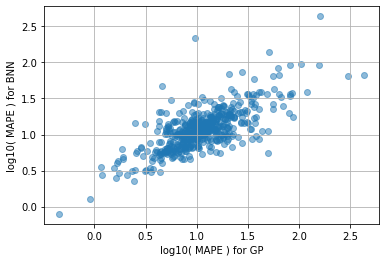

In [33]:
plt.scatter(np.log10(report_gp['MAPE'].values.astype(np.float)), 
            np.log10(report_bnn['MAPE'].values.astype(np.float)), alpha=0.5)
plt.xlabel("log10( MAPE ) for GP")
plt.ylabel("log10( MAPE ) for BNN")
plt.grid(b=1)
plt.show()

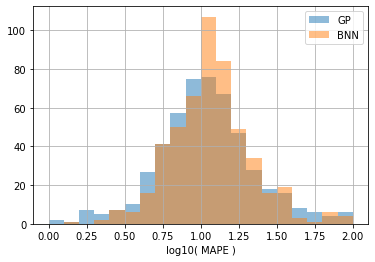

In [34]:
bins = np.linspace(0, 2, 21)
plt.hist(np.log10(report_gp['MAPE'].values.astype(np.float)), bins=bins, alpha=0.5, label='GP')
plt.hist(np.log10(report_bnn['MAPE'].values.astype(np.float)), bins=bins, alpha=0.5, label='BNN')
plt.xlabel("log10( MAPE )")
plt.grid(b=1)
plt.legend()
plt.show()